<a href="https://colab.research.google.com/github/jarodchristiansen/PythonProjects/blob/master/Bitcoin_TA_Daily_Prophet_Bokeh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
from_symbol = 'BTC'
to_symbol = 'USD'
exchange = 'Bitstamp'
datetime_interval = 'day'

In [83]:
import requests
from datetime import datetime
import pandas as pd
 
def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)
def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,\
        'datetime_interval should be one of %s' % supported_intervals
    print('Downloading %s trading data for %s %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)
    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data
def convert_to_dataframe(data):
    df = pd.io.json.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df
def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print('Filtering %d empty datapoints' % indices.shape[0])
    df = df.drop(indices)
    return df
data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)
current_datetime = datetime.now().date().isoformat()
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)

Filtering 0 empty datapoints
Saving data to BTC_USD_Bitstamp_day_2020-09-19.csv


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [84]:
import pandas as pd
def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    # change type from object to datetime
    df.datetime = pd.to_datetime(df.datetime) 
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df
btc = read_dataset(filename)

Reading data from BTC_USD_Bitstamp_day_2020-09-19.csv
(2001, 6)


In [85]:
btc

,low,high,open,close,volumefrom,volumeto
datetime,,,,,,
2015-03-30,236.52,248.86,242.19,247.69,7880.41,1929807.46
2015-03-31,238.55,248.59,247.69,243.98,8180.68,1993776.43
2015-04-01,239.32,246.83,243.98,245.98,6106.97,1484287.63
2015-04-02,244.52,256.96,245.98,253.16,9880.07,2471179.83
2015-04-03,251.23,256.67,253.16,253.79,5062.49,1286655.62
...,...,...,...,...,...,...
2020-09-15,10611.17,10940.01,10675.15,10783.83,6456.66,69707532.15
2020-09-16,10662.81,11100.00,10783.83,10951.54,8300.24,90789916.42
2020-09-17,10739.23,11054.00,10951.54,10940.47,5525.72,60068052.25


In [86]:
!pip install stockstats

In [87]:
from stockstats import StockDataFrame
df = StockDataFrame.retype(btc)
df['macd'] = df.get('macd') # calculate MACD

CRITICAL:stockstats:NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


In [88]:
df

,low,high,open,close,volumefrom,volumeto,macd,macds,macdh
datetime,,,,,,,,,
2015-03-30,236.52,248.86,242.19,247.69,7880.41,1929807.46,0.000000,0.000000,0.000000
2015-03-31,238.55,248.59,247.69,243.98,8180.68,1993776.43,-0.083237,-0.046243,-0.036994
2015-04-01,239.32,246.83,243.98,245.98,6106.97,1484287.63,-0.044041,-0.045340,0.001300
2015-04-02,244.52,256.96,245.98,253.16,9880.07,2471179.83,0.234097,0.049320,0.184777
2015-04-03,251.23,256.67,253.16,253.79,5062.49,1286655.62,0.405374,0.155238,0.250136
...,...,...,...,...,...,...,...,...,...
2020-09-15,10611.17,10940.01,10675.15,10783.83,6456.66,69707532.15,-223.015155,-240.490547,17.475393
2020-09-16,10662.81,11100.00,10783.83,10951.54,8300.24,90789916.42,-177.370887,-227.866615,50.495728
2020-09-17,10739.23,11054.00,10951.54,10940.47,5525.72,60068052.25,-140.471465,-210.387585,69.916121


In [89]:
price = df['close']
 
shortest_rolling = price.rolling(window=5).mean()
short_rolling = price.rolling(window=20).mean()
long_rolling = price.rolling(window=120).mean()
 
ema_short = price.ewm(span=10, adjust=False).mean()
ema_mid = price.ewm(span=20, adjust=False).mean()
ema_long = price.ewm(span=120, adjust=False).mean()
 
 
df['sma5'] = shortest_rolling
df['sma20'] = short_rolling
df['sma120'] = long_rolling
 
df['ema10'] = ema_short
df['ema20'] = ema_mid
df['ema120'] = ema_long
 
df.head(51)

,low,high,open,close,volumefrom,volumeto,macd,macds,macdh,sma5,sma20,sma120,ema10,ema20,ema120
datetime,,,,,,,,,,,,,,,
2015-03-30,236.52,248.86,242.19,247.69,7880.41,1929807.46,0.000000,0.000000,0.000000,NaN,NaN,NaN,247.690000,247.690000,247.690000
2015-03-31,238.55,248.59,247.69,243.98,8180.68,1993776.43,-0.083237,-0.046243,-0.036994,NaN,NaN,NaN,247.015455,247.336667,247.628678
2015-04-01,239.32,246.83,243.98,245.98,6106.97,1484287.63,-0.044041,-0.045340,0.001300,NaN,NaN,NaN,246.827190,247.207460,247.601427
2015-04-02,244.52,256.96,245.98,253.16,9880.07,2471179.83,0.234097,0.049320,0.184777,NaN,NaN,NaN,247.978610,247.774369,247.693304
2015-04-03,251.23,256.67,253.16,253.79,5062.49,1286655.62,0.405374,0.155238,0.250136,248.920,NaN,NaN,249.035226,248.347286,247.794076
2015-04-04,250.76,255.85,253.79,253.45,2579.58,652406.55,0.486176,0.244941,0.241235,250.072,NaN,NaN,249.837913,248.833259,247.887562
2015-04-05,251.65,261.00,253.45,260.50,5807.32,1491248.36,0.848998,0.397811,0.451187,253.376,NaN,NaN,251.776474,249.944377,248.096032
2015-04-06,254.00,262.98,260.50,255.83,5989.94,1543244.68,0.856526,0.508049,0.348477,255.346,NaN,NaN,252.513479,250.504913,248.223866
2015-04-07,251.50,256.62,255.83,254.45,5990.22,1522986.50,0.780240,0.570927,0.209313,255.604,NaN,NaN,252.865573,250.880635,248.326778


Level Price
0  11100
0.236 11060.116
0.382 11035.442
0.618 10995.558
1  10931


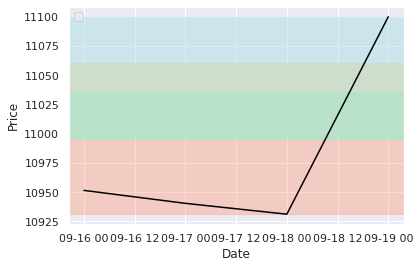

In [91]:
import matplotlib.pyplot as plt
 
fibs = df['close'][-2::]
 
price_min = fibs.min()
price_max = fibs.max()
 
price_min = int(price_min)
price_min
 
price_max = int(price_max)
price_max
 
 
diff = price_max - price_min
 
level1 = price_max - 0.236 * diff
level2 = price_max - 0.382 * diff
level3 = price_max - 0.618 * diff
 
print("Level", "Price")
print("0 ", price_max)
print("0.236", level1)
print("0.382", level2)
print("0.618", level3)
print("1 ", price_min)
 
 
 
fig, ax = plt.subplots()
ax.plot(btc['close'][-4::], color='black')
ax.axhspan(level1, price_min, alpha=0.4, color='lightsalmon')
ax.axhspan(level2, level1, alpha=0.5, color='palegoldenrod')
ax.axhspan(level3, level2, alpha=0.5, color='palegreen')
ax.axhspan(price_max, level3, alpha=0.5, color='powderblue')
 
plt.ylabel("Price")
plt.xlabel("Date")
plt.legend(loc=2)
plt.show()

In [112]:
!pip install bokeh
from bokeh.models import BoxAnnotation
from bokeh.plotting import figure, output_file, show
from bokeh.models import PolyDrawTool
from bokeh.models import ColumnDataSource

TOOLS = "pan,wheel_zoom, poly_draw, box_zoom,reset,save"
source = ColumnDataSource('xs', 'ys')

from math import pi
from bokeh.plotting import figure, show, output_notebook, output_file
output_notebook()
datetime_from = '2015-03-23 00:00'
datetime_to = '2020-09-19 00:00'
def get_candlestick_width(datetime_interval):
    if datetime_interval == 'minute':
        return 30 * 60 * 1000  # half minute in ms
    elif datetime_interval == 'hour':
        return 0.5 * 60 * 60 * 1000  # half hour in ms
    elif datetime_interval == 'day':
        return 12 * 60 * 60 * 1000  # half day in ms
df_limit = df[datetime_from: datetime_to].copy()
inc = df_limit.close > df_limit.open
dec = df_limit.open > df_limit.close
title = '%s datapoints from %s to %s for %s and %s from %s with MACD strategy' % (
    datetime_interval, datetime_from, datetime_to, from_symbol, to_symbol, exchange)
p = figure(x_axis_type="datetime",  plot_width=1500, title=title, tools=TOOLS)
p.line(df_limit.index, df_limit.close, color='black')
# plot macd strategy
p.line(df_limit.index, 0, color='black')
p.line(df_limit.index, df_limit.macd, color='blue')
p.line(df_limit.index, df_limit.macds, color='orange')



low_box = BoxAnnotation(top=level1, fill_alpha=0.1, fill_color='blue')
mid_box = BoxAnnotation(bottom=level2, top=180, fill_alpha=0.1, fill_color='yellow')
high_box = BoxAnnotation(bottom=level3, fill_alpha=0.1, fill_color='red')

p.add_layout(low_box)
p.add_layout(mid_box)
p.add_layout(high_box)

p.xgrid[0].grid_line_color=None
p.ygrid[0].grid_line_alpha=0.5
p.vbar(x=df_limit.index, bottom=[
       0 for _ in df_limit.index], top=df_limit.macdh, width=10, color="purple")
# plot candlesticks
candlestick_width = get_candlestick_width(datetime_interval)
p.segment(df_limit.index, df_limit.high,
          df_limit.index, df_limit.low, color="black")
p.vbar(df_limit.index[inc], candlestick_width, df_limit.open[inc],
       df_limit.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df_limit.index[dec], candlestick_width, df_limit.open[dec],
       df_limit.close[dec], fill_color="#F2583E", line_color="black")
p.line(df_limit.index, df_limit.ema10, color='red', line_width=2)
p.line(df_limit.index, df_limit.sma120, color='teal', line_width=3)

r = p.multi_line(source=source)
tool = PolyDrawTool(renderers=[r])
p.add_tools(tool)


output_file("visualizing_trading_strategy.html", title="visualizing trading strategy")
show(p)


INFO:bokeh.io.state:Session output file 'visualizing_trading_strategy.html' already exists, will be overwritten.


In [15]:
trading_positions_raw = price - ema_short
trading_positions_raw.tail()

datetime
2020-09-15    227.215691
2020-09-16    323.121020
2020-09-17    255.314471
2020-09-18    201.309113
2020-09-19    302.816547
Name: close, dtype: float64

In [ ]:
import numpy as np

trading_positions = trading_positions_raw.apply(np.sign) * 1/3
trading_positions.tail()

datetime
2020-09-09   -0.333333
2020-09-10   -0.333333
2020-09-11   -0.333333
2020-09-12   -0.333333
2020-09-13   -0.333333
Name: close, dtype: float64

In [22]:
df

,low,high,open,close,volumefrom,volumeto,macd,macds,macdh,sma5,sma20,sma50,ema10,ema20,ema50,sma120,ema120
datetime,,,,,,,,,,,,,,,,,
2015-03-30,236.52,248.86,242.19,247.69,7880.41,1929807.46,0.000000,0.000000,0.000000,NaN,NaN,NaN,247.690000,247.690000,247.690000,NaN,247.690000
2015-03-31,238.55,248.59,247.69,243.98,8180.68,1993776.43,-0.083237,-0.046243,-0.036994,NaN,NaN,NaN,247.015455,247.336667,247.544510,NaN,247.628678
2015-04-01,239.32,246.83,243.98,245.98,6106.97,1484287.63,-0.044041,-0.045340,0.001300,NaN,NaN,NaN,246.827190,247.207460,247.483156,NaN,247.601427
2015-04-02,244.52,256.96,245.98,253.16,9880.07,2471179.83,0.234097,0.049320,0.184777,NaN,NaN,NaN,247.978610,247.774369,247.705778,NaN,247.693304
2015-04-03,251.23,256.67,253.16,253.79,5062.49,1286655.62,0.405374,0.155238,0.250136,248.920,NaN,NaN,249.035226,248.347286,247.944375,NaN,247.794076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-15,10611.17,10940.01,10675.15,10783.83,6456.66,69707532.15,-223.015155,-240.490547,17.475393,10526.026,10788.7480,11273.3630,10556.614309,10732.778794,10815.243753,10180.233667,10233.612757
2020-09-16,10662.81,11100.00,10783.83,10951.54,8300.24,90789916.42,-177.370887,-227.866615,50.495728,10637.726,10769.8250,11273.6084,10628.418980,10753.613194,10820.588704,10189.932750,10245.479323
2020-09-17,10739.23,11054.00,10951.54,10940.47,5525.72,60068052.25,-140.471465,-210.387585,69.916121,10737.154,10740.0195,11270.1944,10685.155529,10771.409081,10825.289931,10201.799083,10256.966772


#prophet models to predict the price, this will be a long term and daily predictor. Daily will rely on open price to predict the daily outcome as it is a time dependent feature.

In [23]:
!pip install sklearn
!pip install fbprophet

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import statsmodels.api as sm
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [25]:
df

,low,high,open,close,volumefrom,volumeto,macd,macds,macdh,sma5,sma20,sma50,ema10,ema20,ema50,sma120,ema120
datetime,,,,,,,,,,,,,,,,,
2015-03-30,236.52,248.86,242.19,247.69,7880.41,1929807.46,0.000000,0.000000,0.000000,NaN,NaN,NaN,247.690000,247.690000,247.690000,NaN,247.690000
2015-03-31,238.55,248.59,247.69,243.98,8180.68,1993776.43,-0.083237,-0.046243,-0.036994,NaN,NaN,NaN,247.015455,247.336667,247.544510,NaN,247.628678
2015-04-01,239.32,246.83,243.98,245.98,6106.97,1484287.63,-0.044041,-0.045340,0.001300,NaN,NaN,NaN,246.827190,247.207460,247.483156,NaN,247.601427
2015-04-02,244.52,256.96,245.98,253.16,9880.07,2471179.83,0.234097,0.049320,0.184777,NaN,NaN,NaN,247.978610,247.774369,247.705778,NaN,247.693304
2015-04-03,251.23,256.67,253.16,253.79,5062.49,1286655.62,0.405374,0.155238,0.250136,248.920,NaN,NaN,249.035226,248.347286,247.944375,NaN,247.794076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-15,10611.17,10940.01,10675.15,10783.83,6456.66,69707532.15,-223.015155,-240.490547,17.475393,10526.026,10788.7480,11273.3630,10556.614309,10732.778794,10815.243753,10180.233667,10233.612757
2020-09-16,10662.81,11100.00,10783.83,10951.54,8300.24,90789916.42,-177.370887,-227.866615,50.495728,10637.726,10769.8250,11273.6084,10628.418980,10753.613194,10820.588704,10189.932750,10245.479323
2020-09-17,10739.23,11054.00,10951.54,10940.47,5525.72,60068052.25,-140.471465,-210.387585,69.916121,10737.154,10740.0195,11270.1944,10685.155529,10771.409081,10825.289931,10201.799083,10256.966772


In [26]:
df.to_csv('btc_w_macd.csv')

In [28]:
df = pd.read_csv('btc_w_macd.csv')

In [29]:
df

,datetime,low,high,open,close,volumefrom,volumeto,macd,macds,macdh,sma5,sma20,sma50,ema10,ema20,ema50,sma120,ema120
0,2015-03-30,236.52,248.86,242.19,247.69,7880.41,1929807.46,0.000000,0.000000,0.000000,NaN,NaN,NaN,247.690000,247.690000,247.690000,NaN,247.690000
1,2015-03-31,238.55,248.59,247.69,243.98,8180.68,1993776.43,-0.083237,-0.046243,-0.036994,NaN,NaN,NaN,247.015455,247.336667,247.544510,NaN,247.628678
2,2015-04-01,239.32,246.83,243.98,245.98,6106.97,1484287.63,-0.044041,-0.045340,0.001300,NaN,NaN,NaN,246.827190,247.207460,247.483156,NaN,247.601427
3,2015-04-02,244.52,256.96,245.98,253.16,9880.07,2471179.83,0.234097,0.049320,0.184777,NaN,NaN,NaN,247.978610,247.774369,247.705778,NaN,247.693304
4,2015-04-03,251.23,256.67,253.16,253.79,5062.49,1286655.62,0.405374,0.155238,0.250136,248.920,NaN,NaN,249.035226,248.347286,247.944375,NaN,247.794076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,2020-09-15,10611.17,10940.01,10675.15,10783.83,6456.66,69707532.15,-223.015155,-240.490547,17.475393,10526.026,10788.7480,11273.3630,10556.614309,10732.778794,10815.243753,10180.233667,10233.612757
1997,2020-09-16,10662.81,11100.00,10783.83,10951.54,8300.24,90789916.42,-177.370887,-227.866615,50.495728,10637.726,10769.8250,11273.6084,10628.418980,10753.613194,10820.588704,10189.932750,10245.479323
1998,2020-09-17,10739.23,11054.00,10951.54,10940.47,5525.72,60068052.25,-140.471465,-210.387585,69.916121,10737.154,10740.0195,11270.1944,10685.155529,10771.409081,10825.289931,10201.799083,10256.966772
1999,2020-09-18,10816.54,11040.18,10940.47,10931.20,4398.92,48037947.48,-110.700333,-190.450135,79.749801,10856.438,10712.9940,11266.5760,10729.890887,10786.627263,10829.443267,10217.371833,10268.111123


In [30]:
s2f_data = pd.read_csv('Bitcoin_Data_With_S2F.csv')

In [31]:
s2f_data

,ds,open,diff,y,volume,market cap,S2F
0,4/28/2013,135.30,0.00,134.21,0,1.488567e+09,6.864391
1,4/29/2013,134.44,10.33,144.54,0,1.603769e+09,6.985530
2,4/30/2013,144.00,-5.54,139.00,0,1.542813e+09,8.160798
3,5/1/2013,139.00,-22.01,116.99,0,1.298955e+09,8.055411
4,5/2/2013,116.38,-11.78,105.21,0,1.168517e+09,9.080454
...,...,...,...,...,...,...,...
2677,8/26/2020,11366.89,122.22,11488.36,22466660958,2.120000e+11,31.093564
2678,8/27/2020,11485.61,-164.96,11323.40,23240415076,2.090000e+11,46.764867
2679,8/28/2020,11325.30,219.10,11542.50,19807127588,2.130000e+11,52.396465
2680,8/29/2020,11541.05,-35.63,11506.87,17485597759,2.130000e+11,3.828725


In [32]:
moving_vol = df['volumeto']

moving_vol_10 = moving_vol.rolling(window=10).mean()

In [36]:
btc = pd.DataFrame()
btc['ds'] = df['datetime']
btc['y'] = df['close']
btc['open'] = df['open']
btc['macd'] = df['macd']
btc['macds'] = df['macds']
btc['moving_vol_10'] = moving_vol_10
btc['S2F'] = s2f_data['S2F']

In [37]:
btc

,ds,y,open,macd,macds,moving_vol_10,S2F
0,2015-03-30,247.69,242.19,0.000000,0.000000,NaN,6.864391
1,2015-03-31,243.98,247.69,-0.083237,-0.046243,NaN,6.985530
2,2015-04-01,245.98,243.98,-0.044041,-0.045340,NaN,8.160798
3,2015-04-02,253.16,245.98,0.234097,0.049320,NaN,8.055411
4,2015-04-03,253.79,253.16,0.405374,0.155238,NaN,9.080454
...,...,...,...,...,...,...,...
1996,2020-09-15,10783.83,10675.15,-223.015155,-240.490547,6.844282e+07,23.436090
1997,2020-09-16,10951.54,10783.83,-177.370887,-227.866615,7.230232e+07,28.126596
1998,2020-09-17,10940.47,10951.54,-140.471465,-210.387585,6.949019e+07,27.517828
1999,2020-09-18,10931.20,10940.47,-110.700333,-190.450135,6.362957e+07,27.520568


In [38]:
btc.describe()

,y,open,macd,macds,moving_vol_10,S2F
count,2001.000000,2001.000000,2001.000000,2001.000000,1.992000e+03,2001.000000
mean,4781.802749,4776.405097,37.330340,37.663911,4.897999e+07,15.576021
std,4099.907026,4098.720046,344.165676,324.629818,5.597204e+07,7.589452
min,211.790000,211.790000,-1442.492102,-1257.737861,1.183995e+06,4.991644
25%,610.340000,608.930000,-32.156891,-32.763213,4.530736e+06,9.247678
50%,4053.870000,4040.710000,6.614061,6.303310,3.489222e+07,11.457471
75%,8205.530000,8200.000000,97.260322,94.549196,6.857324e+07,23.333942
max,19187.780000,19187.780000,2537.230185,2280.109007,3.549301e+08,45.686267


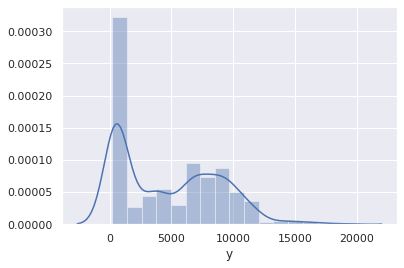

In [39]:
sns.distplot(btc['y'])

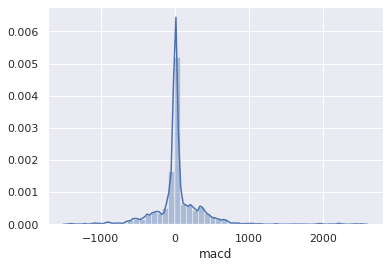

In [40]:
sns.distplot(btc['macd'])

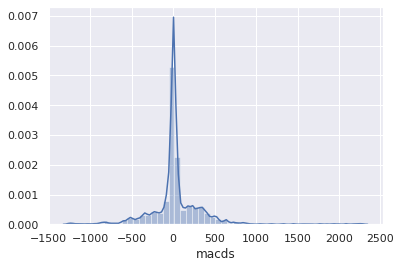

In [41]:
sns.distplot(btc['macds'])

In [42]:
btc.to_csv('btc_macd_ema_s2f.csv')

In [ ]:
btc = pd.read_csv('btc_macd_ema_s2f.csv')

In [44]:
btc['ema'] = df['ema10']

In [45]:
btc

,ds,y,open,macd,macds,moving_vol_10,S2F,ema
0,2015-03-30,247.69,242.19,0.000000,0.000000,NaN,6.864391,247.690000
1,2015-03-31,243.98,247.69,-0.083237,-0.046243,NaN,6.985530,247.015455
2,2015-04-01,245.98,243.98,-0.044041,-0.045340,NaN,8.160798,246.827190
3,2015-04-02,253.16,245.98,0.234097,0.049320,NaN,8.055411,247.978610
4,2015-04-03,253.79,253.16,0.405374,0.155238,NaN,9.080454,249.035226
...,...,...,...,...,...,...,...,...
1996,2020-09-15,10783.83,10675.15,-223.015155,-240.490547,6.844282e+07,23.436090,10556.614309
1997,2020-09-16,10951.54,10783.83,-177.370887,-227.866615,7.230232e+07,28.126596,10628.418980
1998,2020-09-17,10940.47,10951.54,-140.471465,-210.387585,6.949019e+07,27.517828,10685.155529
1999,2020-09-18,10931.20,10940.47,-110.700333,-190.450135,6.362957e+07,27.520568,10729.890887


In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = btc[['y', 'macd', "S2F", 'ema']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i ) for i in range(variables.shape[1])]
vif["features"] = variables.columns

In [55]:
vif

,VIF,features
0,325.162998,y
1,1.585309,macd
2,4.198071,S2F
3,315.581335,ema


In [68]:
btc_train,btc_test = train_test_split(btc, test_size=0.08, shuffle=False)

In [ ]:
del btc_model

In [69]:
from fbprophet import Prophet
btc_daily = Prophet(daily_seasonality = True) # the Prophet class (model)
btc_daily.add_regressor('macd')
btc_daily.add_regressor('S2F')
btc_daily.add_regressor('open')
btc_daily.add_regressor('ema')

btc_daily.fit(btc_train) # fit the model using all data

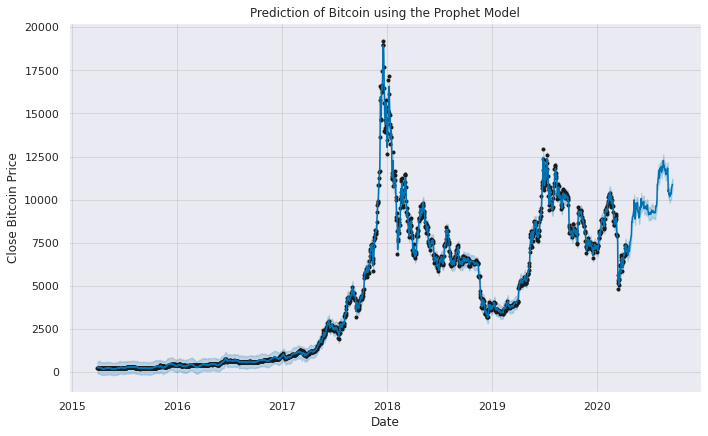

In [70]:
prediction = btc_daily.predict(btc)
btc_daily.plot(prediction)
plt.title("Prediction of Bitcoin using the Prophet Model")
plt.xlabel("Date")
plt.ylabel("Close Bitcoin Price")
plt.show()

#By limiting the train/test split to 5% the result become much more accurate. I believe this indicates that this model will be better at detecting moderately short term movements (10 days or so). This is most likely due to the windows used for moving average and volatility in the market. Although the results of the 15% split were still moderately accurate, but with a larger spike to 15k. 

#This will impact the range of forecasting this model will produce before a wide range of volatility (potentially 10 day windows will be best?)


#I am undecided if the spike it called for is just being prolonged or if the recent whale moves (sept 2020) artificially delayed the pump to a later time after accumulation. To attempt and predict this I will create a seperate prophet model to predict moving volume and S2F. These will then be combined with the results of the MACD forecaster to make a prediction in this model. Each will need to be refined to reduce loss.  

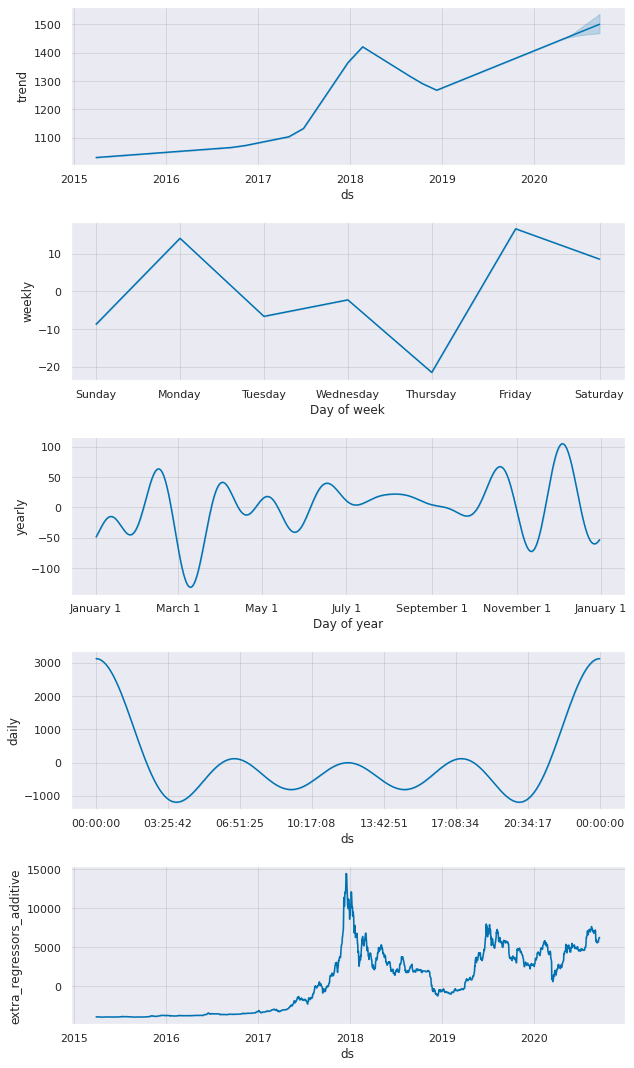

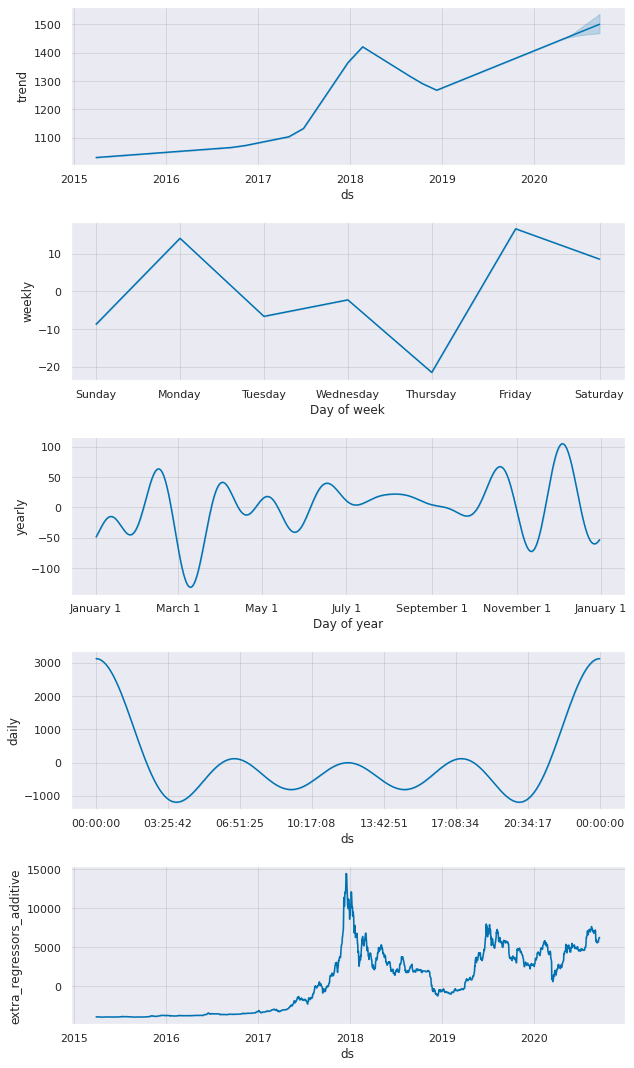

In [71]:
btc_daily.plot_components(prediction)

In [72]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,S2F,S2F_lower,S2F_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,ema,ema_lower,ema_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,macd,macd_lower,macd_upper,open,open_lower,open_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-03-30,1030.423236,-58.748106,641.539607,1030.423236,1030.423236,24.622836,24.622836,24.622836,-753.212057,-753.212057,-753.212057,3132.869034,3132.869034,3132.869034,-1127.444793,-1127.444793,-1127.444793,-3932.080403,-3932.080403,-3932.080403,-8.194534,-8.194534,-8.194534,-2821.063912,-2821.063912,-2821.063912,14.043996,14.043996,14.043996,31.955316,31.955316,31.955316,0.0,0.0,0.0,277.211178
1,2015-03-31,1030.488408,-67.719834,634.201535,1030.488408,1030.488408,24.243611,24.243611,24.243611,-766.380805,-766.380805,-766.380805,3132.869034,3132.869034,3132.869034,-1127.631109,-1127.631109,-1127.631109,-3928.888834,-3928.888834,-3928.888834,-8.221635,-8.221635,-8.221635,-2817.279702,-2817.279702,-2817.279702,-6.637118,-6.637118,-6.637118,36.276113,36.276113,36.276113,0.0,0.0,0.0,264.107602
2,2015-04-01,1030.553580,-59.451266,604.057718,1030.553580,1030.553580,20.564432,20.564432,20.564432,-765.272637,-765.272637,-765.272637,3132.869034,3132.869034,3132.869034,-1127.683109,-1127.683109,-1127.683109,-3935.159874,-3935.159874,-3935.159874,-8.208873,-8.208873,-8.208873,-2819.832323,-2819.832323,-2819.832323,-2.268778,-2.268778,-2.268778,39.286981,39.286981,39.286981,0.0,0.0,0.0,265.280943
3,2015-04-02,1030.618752,-111.851123,571.428453,1030.618752,1030.618752,20.894345,20.894345,20.894345,-780.654560,-780.654560,-780.654560,3132.869034,3132.869034,3132.869034,-1127.365075,-1127.365075,-1127.365075,-3933.045294,-3933.045294,-3933.045294,-8.118317,-8.118317,-8.118317,-2818.456247,-2818.456247,-2818.456247,-21.488120,-21.488120,-21.488120,41.009820,41.009820,41.009820,0.0,0.0,0.0,249.964192
4,2015-04-03,1030.683924,-53.862682,643.039311,1030.683924,1030.683924,17.685448,17.685448,17.685448,-740.046919,-740.046919,-740.046919,3132.869034,3132.869034,3132.869034,-1127.073227,-1127.073227,-1127.073227,-3930.966464,-3930.966464,-3930.966464,-8.062552,-8.062552,-8.062552,-2813.516133,-2813.516133,-2813.516133,16.553552,16.553552,16.553552,41.496960,41.496960,41.496960,0.0,0.0,0.0,290.637005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,2020-09-15,1498.846188,10233.203834,10959.176202,1468.473460,1534.322858,-27.254895,-27.254895,-27.254895,9091.584914,9091.584914,9091.584914,3132.869034,3132.869034,3132.869034,1719.984984,1719.984984,1719.984984,5969.136677,5969.136677,5969.136677,-80.804194,-80.804194,-80.804194,4357.210781,4357.210781,4357.210781,-6.637118,-6.637118,-6.637118,-3.783679,-3.783679,-3.783679,0.0,0.0,0.0,10590.431102
1997,2020-09-16,1499.205585,10326.346107,11019.769758,1468.759740,1534.927743,-41.938531,-41.938531,-41.938531,9189.652286,9189.652286,9189.652286,3132.869034,3132.869034,3132.869034,1739.818165,1739.818165,1739.818165,6063.923149,6063.923149,6063.923149,-65.943254,-65.943254,-65.943254,4431.986769,4431.986769,4431.986769,-2.268778,-2.268778,-2.268778,-4.871119,-4.871119,-4.871119,0.0,0.0,0.0,10688.857871
1998,2020-09-17,1499.564983,10468.715789,11173.208870,1468.862544,1535.515999,-40.032783,-40.032783,-40.032783,9314.251859,9314.251859,9314.251859,3132.869034,3132.869034,3132.869034,1755.489377,1755.489377,1755.489377,6208.904768,6208.904768,6208.904768,-53.929476,-53.929476,-53.929476,4547.377650,4547.377650,4547.377650,-21.488120,-21.488120,-21.488120,-6.033823,-6.033823,-6.033823,0.0,0.0,0.0,10813.816842
1999,2020-09-18,1499.924381,10501.936587,11236.516167,1468.804296,1536.123976,-40.041360,-40.041360,-40.041360,9365.50

In [73]:
!pip install bokeh

In [74]:
btc['pred_date_2'] = prediction['ds']
btc['full_preds'] = prediction['yhat']

btc.to_csv('btc_s2f_vol_macd_preds.csv')

In [75]:
btc['full_results'] = btc['y'].sub(btc['full_preds'])

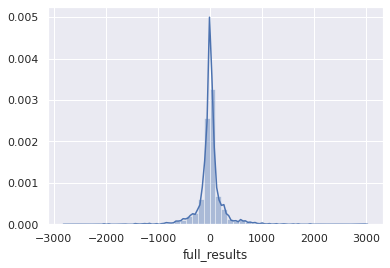

In [76]:
sns.distplot(btc['full_results'])

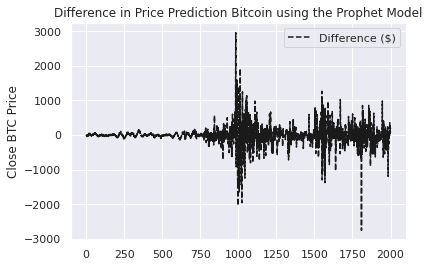

In [79]:
results = btc['full_results']
plt.figure(); results.plot(style='k--', label='Difference ($)'); plt.legend()
plt.title("Difference in Price Prediction Bitcoin using the Prophet Model")
#plt.xlabel("Date")
plt.ylabel("Close BTC Price")
plt.show()

In [80]:
btc

,ds,y,open,macd,macds,moving_vol_10,S2F,ema,pred_date_2,full_preds,full_results
0,2015-03-30,247.69,242.19,0.000000,0.000000,NaN,6.864391,247.690000,2015-03-30,277.211178,-29.521178
1,2015-03-31,243.98,247.69,-0.083237,-0.046243,NaN,6.985530,247.015455,2015-03-31,264.107602,-20.127602
2,2015-04-01,245.98,243.98,-0.044041,-0.045340,NaN,8.160798,246.827190,2015-04-01,265.280943,-19.300943
3,2015-04-02,253.16,245.98,0.234097,0.049320,NaN,8.055411,247.978610,2015-04-02,249.964192,3.195808
4,2015-04-03,253.79,253.16,0.405374,0.155238,NaN,9.080454,249.035226,2015-04-03,290.637005,-36.847005
...,...,...,...,...,...,...,...,...,...,...,...
1996,2020-09-15,10783.83,10675.15,-223.015155,-240.490547,6.844282e+07,23.436090,10556.614309,2020-09-15,10590.431102,193.398898
1997,2020-09-16,10951.54,10783.83,-177.370887,-227.866615,7.230232e+07,28.126596,10628.418980,2020-09-16,10688.857871,262.682129
1998,2020-09-17,10940.47,10951.54,-140.471465,-210.387585,6.949019e+07,27.517828,10685.155529,2020-09-17,10813.816842,126.653158
1999,2020-09-18,10931.20,10940.47,-110.700333,-190.450135,6.362957e+07,27.520568,10729.890887,2020-09-18,10865.426639,65.773361


In [ ]:
btc.to_csv('macd_preds_1.csv')

In [ ]:
macd = pd.read_csv('macd_90_day.csv')
macds = pd.read_csv('macds_90_day.csv')

In [ ]:
macd

,Unnamed: 0,ds,macd
0,0,2020-09-13,-2.285816
1,1,2020-09-14,-1.593737
2,2,2020-09-15,-3.378605
3,3,2020-09-16,-4.592652
4,4,2020-09-17,-7.538097
...,...,...,...
85,85,2020-12-07,232.529357
86,86,2020-12-08,253.046931
87,87,2020-12-09,272.495076
88,88,2020-12-10,288.332172


In [ ]:
macds

,Unnamed: 0,ds,macds
0,0,2020-09-13,24.927269
1,1,2020-09-14,23.080833
2,2,2020-09-15,20.464899
3,3,2020-09-16,18.112621
4,4,2020-09-17,15.600698
...,...,...,...
85,85,2020-12-07,158.638485
86,86,2020-12-08,178.401452
87,87,2020-12-09,198.042718
88,88,2020-12-10,216.866016


In [ ]:
future = pd.DataFrame()
future['ds'] = macds['ds']
future['macd'] = macd['macd']
future['macds'] = macds['macds']

In [ ]:
future

,ds,macd,macds
0,2020-09-13,-2.285816,24.927269
1,2020-09-14,-1.593737,23.080833
2,2020-09-15,-3.378605,20.464899
3,2020-09-16,-4.592652,18.112621
4,2020-09-17,-7.538097,15.600698
...,...,...,...
85,2020-12-07,232.529357,158.638485
86,2020-12-08,253.046931,178.401452
87,2020-12-09,272.495076,198.042718
88,2020-12-10,288.332172,216.866016


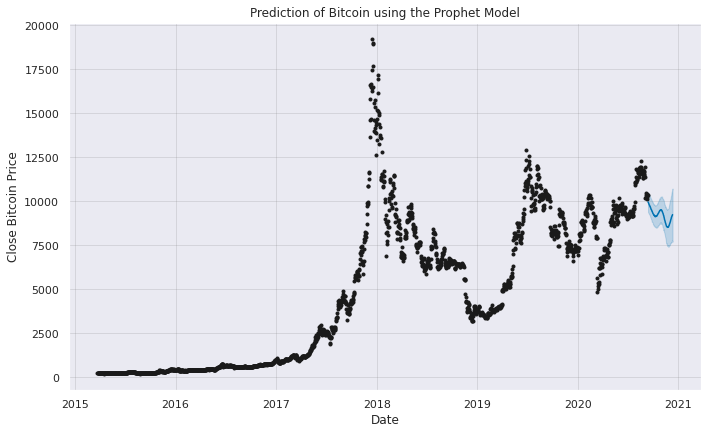

In [ ]:
prediction = btc_model.predict(future)
btc_model.plot(prediction)
plt.title("Prediction of Bitcoin using the Prophet Model")
plt.xlabel("Date")
plt.ylabel("Close Bitcoin Price")
plt.show()

In [ ]:
macd_365 = pd.read_csv('macd_365_day.csv')
macds_365 = pd.read_csv('macds_365_day.csv')

In [ ]:
future_year = pd.DataFrame()
future_year['ds'] = macds_365['ds']
future_year['macd'] = macd_365['macd']
future_year['macds'] = macds_365['macds']

In [ ]:
future_year

,ds,macd,macds
0,2020-09-13,-2.285816,24.927269
1,2020-09-14,-1.593737,23.080833
2,2020-09-15,-3.378605,20.464899
3,2020-09-16,-4.592652,18.112621
4,2020-09-17,-7.538097,15.600698
...,...,...,...
360,2021-09-08,46.985318,82.288787
361,2021-09-09,41.062455,76.868975
362,2021-09-10,37.476613,71.940141
363,2021-09-11,35.211040,67.649030


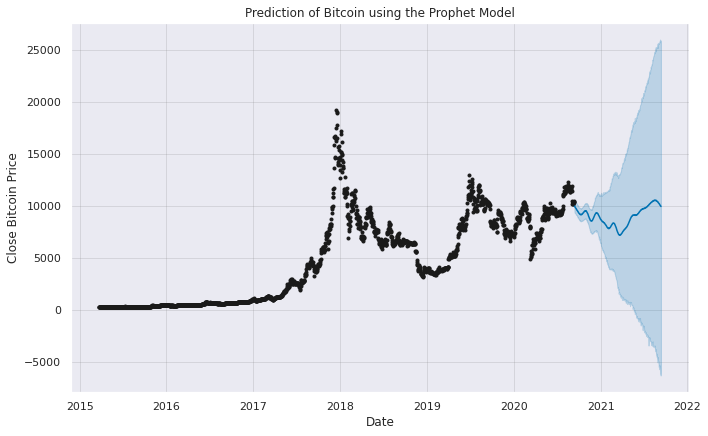

In [ ]:
prediction = btc_model.predict(future_year)
btc_model.plot(prediction)
plt.title("Prediction of Bitcoin using the Prophet Model")
plt.xlabel("Date")
plt.ylabel("Close Bitcoin Price")
plt.show()

In [ ]:
macd_180 = pd.read_csv('macd_180_day.csv')
macds_180 = pd.read_csv('macds_180_day.csv')

In [ ]:
future_6 = pd.DataFrame()
future_6['ds'] = macds_180['ds']
future_6['macd'] = macd_180['macd']
future_6['macds'] = macds_180['macds']

In [ ]:
future_6

,ds,macd,macds
0,2020-09-13,-2.285816,24.927269
1,2020-09-14,-1.593737,23.080833
2,2020-09-15,-3.378605,20.464899
3,2020-09-16,-4.592652,18.112621
4,2020-09-17,-7.538097,15.600698
...,...,...,...
175,2021-03-07,17.917948,66.755723
176,2021-03-08,0.202566,55.442727
177,2021-03-09,-20.839906,41.592955
178,2021-03-10,-41.691321,26.546260


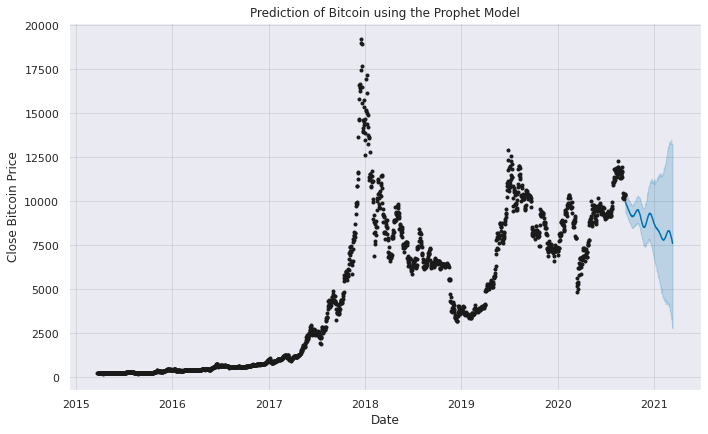

In [ ]:
prediction = btc_model.predict(future_6)
btc_model.plot(prediction)
plt.title("Prediction of Bitcoin using the Prophet Model")
plt.xlabel("Date")
plt.ylabel("Close Bitcoin Price")
plt.show()